<h1><center>LDA implementation step by step</center></h1>

LDA a methed that aims to maximaze the searation between two or more groups by:
1. Maximize the between-groups variance (The difference between means)
2. Minimize the within-groups variance (The variance within each category)

In [2]:
# Libraries needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

In [426]:
#@title LDA function 
def LDA(X, y, n_component):
  n_features = X.shape[1]        # Number of features; (_, n_features = X.shape)
  class_labels = np.unique(y)    # The array of categories

  # Computing the d-dimensional mean vectors
  mean_vectors = []
  for cl in class_labels:
    mean_vectors.append(np.mean(X[y == cl], axis=0))

  # The within-class scatter matrix
  SW = np.zeros((n_features, n_features))                               # Initialize SW; square matrix (n_features)
  for cl, mv in zip(class_labels, mean_vectors):                        
    class_sc_mat = np.zeros((n_features, n_features))                   # Scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1) # Make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    SW += class_sc_mat

  # Overall mean 
  overall_mean = np.mean(X, axis=0)

  # The between-class scatter matrix SB
  SB = np.zeros((n_features, n_features))                                               # Initialize SW; square matrix (n_features)             
  for i, mv in enumerate(mean_vectors):                                                 # (i for indexes, mv for mean_vectors)
    n = X[y == i, :].shape[0]                                                           # Number of rows in the class i
    mv, overall_mean = mv.reshape(n_features, 1), overall_mean.reshape(n_features, 1)   # Make column vector
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)

  # Solving the generalized eigenvalue problem for the matrix SW^(-1)*SB
  eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))

  # Make a list of (eigenvalue, eigenvector) tuples
  eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]  

  # Sorting the eigenvectors by decreasing eigenvalues
  eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

  # Choosing k eigenvectors with the largest eigenvalues
  W = np.hstack((eig_pairs[0][1].reshape(n_features, 1), eig_pairs[1][1].reshape(n_features, 1)))

  # Transforming the samples onto the new subspace
  X_lda = X.dot(W)

  return X_lda

**Linear Discriminant Analysis or LDA** <br>


---


Linear Discriminant Analysis can be broken up into the following steps:


1. Compute the within class and between class scatter matrices
2. Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
3. Sort the eigenvalues and select the top k
4. Create a new matrix containing eigenvectors that map to the k eigenvalues
5. Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4


---




In [80]:
# Load 'wine' dataset
wine = load_wine()
X = wine.data
y = wine.target 

In [83]:
# Conver to pandas dataframe
df = pd.DataFrame(data=np.c_[wine['data'], wine['target']], columns=wine['feature_names']+['target'])
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [84]:
# 'wine' dataset shape
df.shape

(178, 14)

<AxesSubplot:xlabel='alcohol', ylabel='Count'>

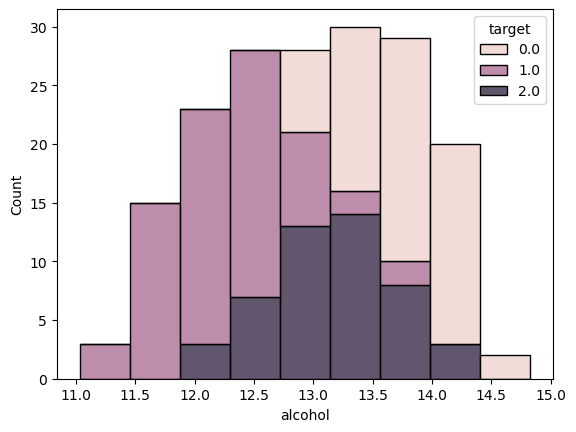

In [85]:
sns.histplot(data=df, x="alcohol", hue="target", multiple="stack")

In [86]:
# Showing the Count of NANs
print(df.isnull().sum())

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64


c:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1.0    71
0.0    59
2.0    48
Name: target, dtype: int64


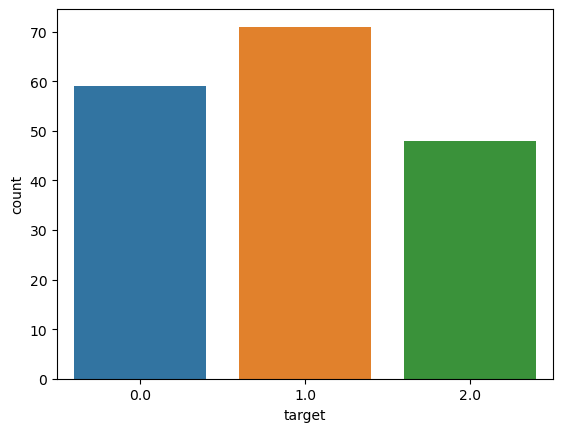

In [87]:
sns.countplot(df['target'])
print(df.target.value_counts())

In [88]:
from sklearn.utils import resample
# create two different dataframe of majority and minority class 
df_2 = df[(df['target']==2)] 
df_1 = df[(df['target']==1)] 
df_0 = df[(df['target']==0)] 

# upsample minority class
df_2_upsampled = resample(df_2, n_samples= 71, random_state=0) 
df_0_upsampled = resample(df_0, n_samples= 71, random_state=0)   

# Combine majority class with upsampled minority class
data = pd.concat([df_0_upsampled, df_2_upsampled, df_1])                              

c:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.0    71
2.0    71
1.0    71
Name: target, dtype: int64


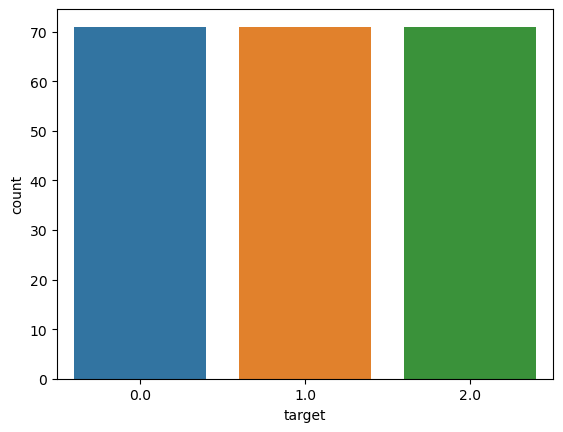

In [89]:
sns.countplot(data['target'])
print(data.target.value_counts())

In [90]:
data.head(2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
44,13.05,1.77,2.10,17.0,107.0,3.0,3.00,0.28,2.03,5.04,0.88,3.35,885.0,0.0
47,13.90,1.68,2.12,16.0,101.0,3.1,3.39,0.21,2.14,6.10,0.91,3.33,985.0,0.0


<AxesSubplot:xlabel='proanthocyanins'>

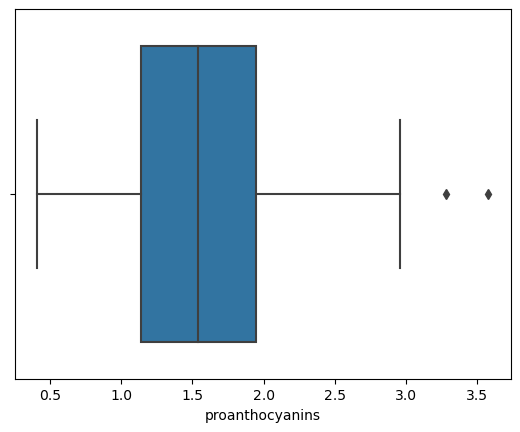

In [91]:
sns.boxplot(x=data["proanthocyanins"])

In [124]:
import scipy.stats as stats
z = np.abs(stats.zscore(data))
data_clean = data[(z<3).all(axis = 1)] 
data_clean.shape

(202, 14)

<AxesSubplot:xlabel='proanthocyanins'>

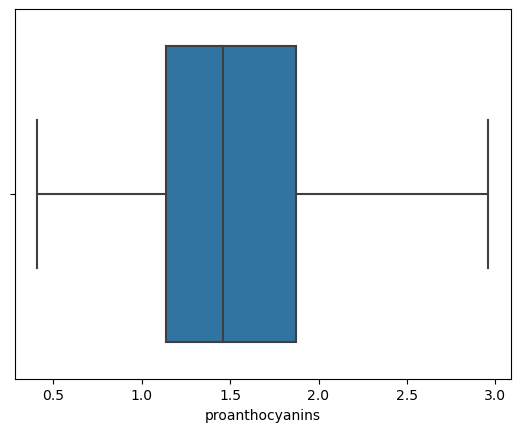

In [93]:
sns.boxplot(x=data_clean["proanthocyanins"])

<AxesSubplot:>

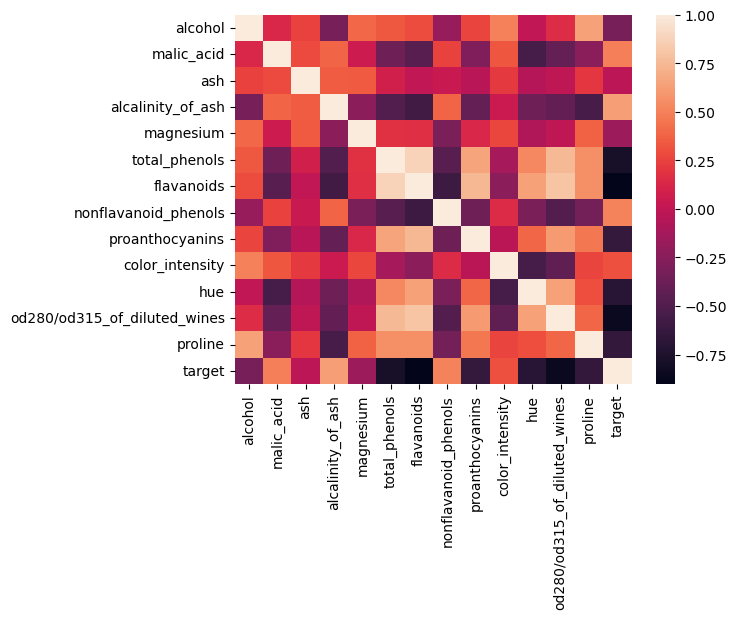

In [94]:
sns.heatmap(data_clean.corr(), fmt='.2g')

In [125]:
X = data_clean.drop('target', axis=1)
y = data_clean['target']

In [430]:
# There are 3 different kinds of wine
pd.Categorical.from_codes(wine.target, wine.target_names)

['class_0', 'class_0', 'class_0', 'class_0', 'class_0', ..., 'class_2', 'class_2', 'class_2', 'class_2', 'class_2']
Length: 178
Categories (3, object): ['class_0', 'class_1', 'class_2']

In [96]:
n_features = X.shape[1]       # Number of features
class_labels = np.unique(y)   # The array of categories

In [118]:
# Computing the d-dimensional mean vectors
mean_vectors = []
for cl in class_labels:
    mean_vectors.append(np.array(np.mean(X[y == cl], axis=0)))

# The Within-class scatter matrix SW
We calculate the within class scatter matrix using the following formula:

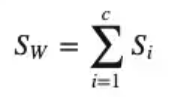

where c is the total number of distinct classes and

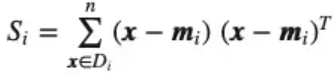

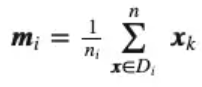

where x is a sample (i.e. row) and n is the total number of samples with a given class.

In [119]:
SW = np.zeros((n_features, n_features))                               # Initialize SW; square matrix (n_features)
for cl, mv in zip(class_labels, mean_vectors):                        # zip to iterate class_labels and mean_vectors simultanously
  class_sc_mat = np.zeros((n_features, n_features))                   # Scatter matrix for every class
  for row in X[y == cl]:
    row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)   # Make column vectors: row and mv are arrays > 
                                                                      # we should make 'em column vectors                              
    class_sc_mat += (row-mv).dot((row-mv).T)
  SW += class_sc_mat

AttributeError: 'str' object has no attribute 'reshape'

# The between-class scatter matrix
Next, we calculate the between class scatter matrix using the following formula:

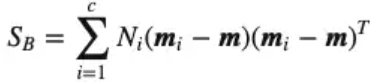

In [435]:
# Overall mean (i.e. mean(X))
overall_mean = np.mean(X, axis=0)

In [436]:
SB = np.zeros((n_features, n_features))                               # Initialize SW; square matrix (n_features)
for i, mv in enumerate(mean_vectors):                                 # (i for indexes, mv for mean_vectors)
    n = X[y == i, :].shape[0]
    mv = mv.reshape(n_features, 1)                                    # Make column vector
    overall_mean = overall_mean.reshape(n_features, 1)                # Make column vector
    SB += n * (mv - overall_mean).dot((mv - overall_mean).T)

In [437]:
# Solving the generalized eigenvalue problem for the matrix SW^(-1)*SB
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))

In [438]:
# Print the eigenvector for each eigenvalue
for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:, i].reshape(n_features, 1)  
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 6.15469180e-01]
 [-6.71700911e-02]
 [-6.17576197e-01]
 [ 4.67066323e-02]
 [-1.68299110e-05]
 [ 4.64870999e-02]
 [ 2.17273250e-02]
 [ 3.20715693e-01]
 [ 8.61633726e-02]
 [-4.21816948e-02]
 [ 3.33505606e-01]
 [-8.47473411e-02]
 [-8.90117477e-04]]
Eigenvalue 1: 0.00e+00

Eigenvector 2: 
[[-2.54446951e-01]
 [-8.91300292e-02]
 [-6.84674307e-01]
 [ 4.27236012e-02]
 [ 1.35062989e-04]
 [ 9.40183328e-03]
 [ 1.43597614e-01]
 [ 4.76020325e-01]
 [ 8.96284915e-02]
 [-7.39094841e-02]
 [ 4.42362517e-01]
 [-1.49388710e-02]
 [-8.32689851e-04]]
Eigenvalue 2: 4.13e+00

Eigenvector 3: 
[[-0.14368315]
 [ 0.05886047]
 [-0.13145742]
 [ 0.055136  ]
 [-0.0007706 ]
 [ 0.22013812]
 [-0.59168399]
 [-0.53278142]
 [ 0.04776118]
 [ 0.12646393]
 [-0.29136853]
 [-0.41230012]
 [-0.00095856]]
Eigenvalue 3: 9.08e+00

Eigenvector 4: 
[[-2.68190295e-01]
 [ 8.83654520e-02]
 [ 7.43968152e-01]
 [-2.27877364e-02]
 [ 1.41425166e-04]
 [ 8.77931755e-02]
 [ 1.54798665e-01]
 [ 7.96317063e-02]
 [-5.68544344e-02]


In [439]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [440]:
# Sorting the eigenvectors by decreasing eigenvalues
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)     # reverse = True: to sort the eigenvectors by decreasing eigenvalues

In [441]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

9.081739435042469
4.128469045639486
6.460554448329267e-16
6.460554448329267e-16
5.649663181094374e-16
5.649663181094374e-16
4.4008258818564415e-16
3.681223491952478e-16
2.389414926840765e-16
2.389414926840765e-16
3.443088528231042e-17
3.443088528231042e-17
0.0


In [442]:
# Calcuate the Variance explained
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i, j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 68.75%
eigenvalue 2: 31.25%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%
eigenvalue 5: 0.00%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%
eigenvalue 12: 0.00%
eigenvalue 13: 0.00%


In [443]:
# Choosing k eigenvectors with the largest eigenvalues
W = np.hstack((eig_pairs[0][1].reshape(n_features, 1), eig_pairs[1][1].reshape(n_features, 1)))
W.real

array([[-1.43683152e-01, -2.54446951e-01],
       [ 5.88604714e-02, -8.91300292e-02],
       [-1.31457424e-01, -6.84674307e-01],
       [ 5.51359957e-02,  4.27236012e-02],
       [-7.70595267e-04,  1.35062989e-04],
       [ 2.20138120e-01,  9.40183328e-03],
       [-5.91683992e-01,  1.43597614e-01],
       [-5.32781421e-01,  4.76020325e-01],
       [ 4.77611849e-02,  8.96284915e-02],
       [ 1.26463935e-01, -7.39094841e-02],
       [-2.91368531e-01,  4.42362517e-01],
       [-4.12300124e-01, -1.49388710e-02],
       [-9.58555352e-04, -8.32689851e-04]])

In [444]:
# Transforming the samples onto the new subspace
X_lda = X.dot(W)

In [123]:
#@title LDA : Results visualization (1)
x1, x2 = X_lda[:, 0], X_lda[:, 1]
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.title('LDA: data projection onto the first 2 linear discriminants\n')
plt.colorbar()
plt.show()

NameError: name 'X_lda' is not defined

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import *

lda = LinearDiscriminantAnalysis()
lda_t = lda.fit_transform(X, y)

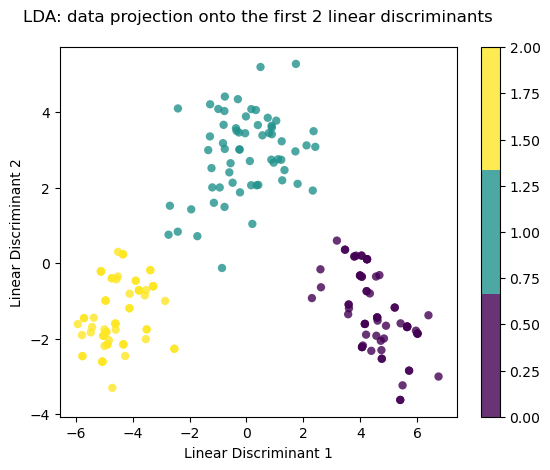

In [127]:
x1, x2 = lda_t[:, 0], lda_t[:, 1]
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Linear Discriminant 2")
plt.title('LDA: data projection onto the first 2 linear discriminants\n')
plt.colorbar()
plt.show()

In [446]:
#@title PCA function
def PCA(X, n_components):
    # step-1 : STANDARISATION
    X = (X - np.mean(X, axis=0))/np.std(X)
    
    # step-2 : CALCULATE COVARIANCE MATRIX
    cov_matrix = np.cov(X, rowvar=False, bias=False)
    
    # step-3 : COMPUTE THE EIGENVECTORS AND EIGENVALUES
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # step-4 : SORT THE EIGEN VECTORS
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    sorted_eigenvectors = eigenvectors[:, sorted_index]
    
    # step-5 : SELECT A SUBSET (n_components = 2) FROM THE REARRANGED EIGENVALUE MATRIX
    eigenvectors_subset = sorted_eigenvectors[:, 0:n_components]
    
    # step-6 : TRANSFORM THE DATA
    X_pca = np.dot(eigenvectors_subset.transpose(), X.transpose()).transpose()
    
    return X_pca

In [447]:
X_pca = PCA(X, 2)

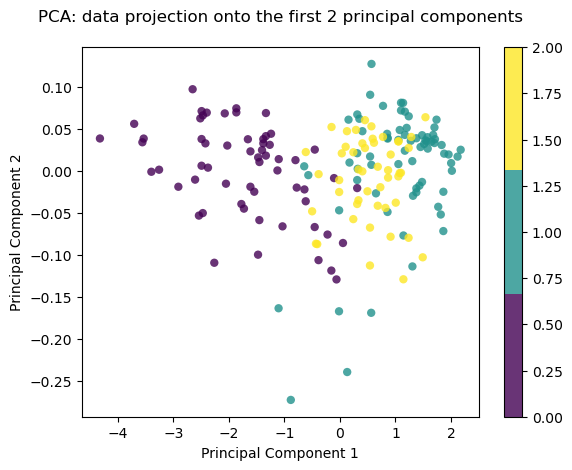

In [448]:
#@title PCA : Results visualization
x1, x2 = X_pca[:, 0], X_pca[:, 1]
plt.scatter(x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA: data projection onto the first 2 principal components\n')
plt.colorbar()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_12200\230084288.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt1.show()
C:\Users\PC\AppData\Local\Temp\ipykernel_12200\230084288.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt2.show()


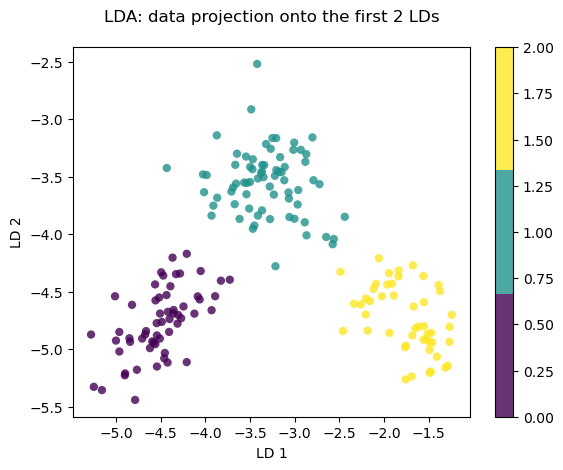

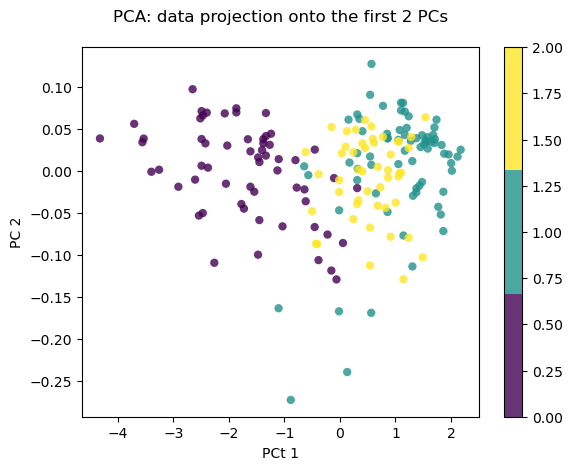

In [449]:
#@title A comparison of PCA and LDA 
plt1 = plt.figure(1)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.title('LDA: data projection onto the first 2 LDs\n')
plt.colorbar()
plt1.show()

plt2 = plt.figure(2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3))
plt.xlabel("PCt 1")
plt.ylabel("PC 2")
plt.title('PCA: data projection onto the first 2 PCs\n')
plt.colorbar()
plt2.show()

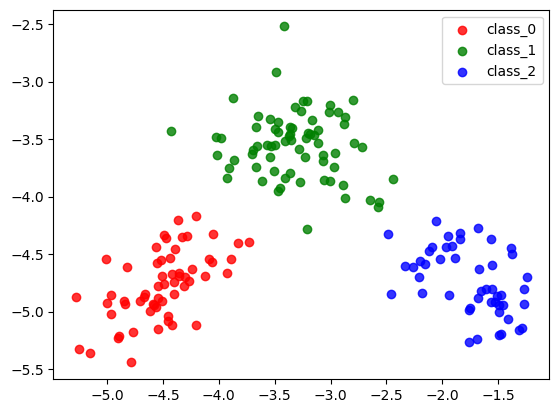

In [450]:
#@title LDA : Results visualization (2)
plt.figure()
colors = ['red', 'green', 'blue']
for color, i, target_name in zip(colors, [0, 1, 2], wine.target_names):
  plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color, label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.show()

L'objectif derriere le calcule des valeurs/ vecteurs propres est de reduire la dimensionalite